<a href="https://colab.research.google.com/github/EvoDmiK/TIL/blob/main/AI_study/basic/pytorch/1.torch_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0. 참고자료**
## **0-1. 도서**
- 한빛 미디어 | 펭귄브로의 3분 딥러닝 - 파이토치 맛

## **0-2. 웹사이트**
## **0-3. 데이터 셋** 

# **1. 인공신경망(ANN)**
- 인공 신경망에서 데이터를 입력받는 부분을 **입력층 (input layer)**라고 한다.
- 입력층을 거친 신호는 **은닉층 (hidden layer | 중간층)**으로 전달된다.
- 은닉층을 지난 신호는 마지막 뉴런인 **출력층(output layer)**으로 전달된다.


(!) 각 층에 존재하는 한 단위의 인공뉴런을 **노드(node)**라 한다.
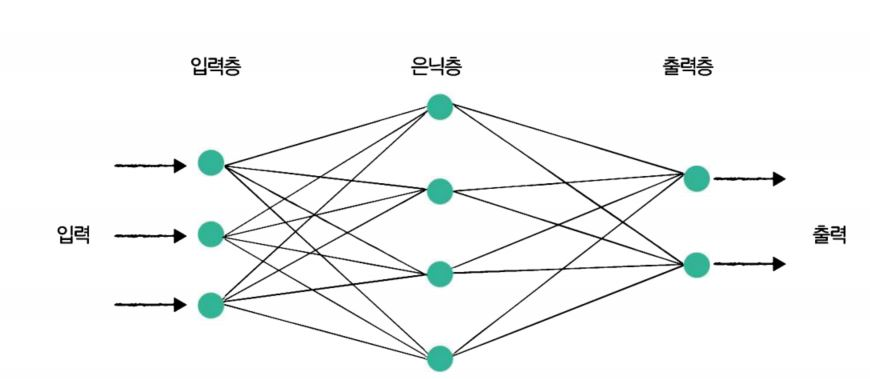

- 각 층에 존재하는 매개변수인 **가중치(weight)**를 행렬곱하고 **편향(bias)**를 더한 결과 값은  
&nbsp;**활성화 함수(activation function)**을 거쳐 다음층으로 신호를 전달한다.
- 인공 신경망의 예측결과와 정답을 비교해 오차를 계산.
- 출력층 ~ 입력층까지의 가중치를 모두 **최적화 함수(optimization function)**을 통해 변경해준다.
- 겹겹이 쌓인 가중치를 뒤에서부터 차례대로 조정하고 최적화하는 알고리즘을  
&nbsp;**역전파 (backpropagation)** 알고리즘이라 한다.


**(!) 가중치 (weight) | 입력 신호가 출력에 주는 영향을 계산하는 매개변수**  
**(!) 편향   (bias)   | 각 노드가 얼마나 데이터에 민감하지 알려주는 매개변수**  
**(!) 활성화 함수 (activation function) | 입력값에 적절한 처리를 하여 출력 신호로 변환하는 함수**  
**(!) 역전파 알고리즘 참조 | [[김성훈 교수님 backpropagation]](https://youtu.be/573EZkzfzZ0)**

## **1-1. 간단한 분류 모델 구현**
- scikit-learn 패키지의 make_blobs() 함수를 이용하여 간단한 분류 모델용 데이터 셋을 생성한다.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import torch

### **(a) 데이터 생성하는 코드**
- (x, y) 순서쌍으로 이루어진 100개의 데이터 셋 생성
- 각 클러스터 별 중심점이 (1, 1), (-1, -1), (1, -1), (-1, 1)이고 표준편차 0.3으로 분포됨.
- 학습용 : 시험용 = 8: 2로 분할함

In [ ]:
n_dims = 2

## scikit-learn의 make_blobs() 함수를 이용해 2차원의 클러스터 데이터 셋이 존재함.
## Y는 0, 1, 2, 3의 4개의 클래스로 구성됨.
X, Y = make_blobs(
                  n_samples = 100, n_features = n_dims, 
                  centers = [[1, 1], [-1, -1], [1, -1], [-1, 1]], 
                  shuffle = True, cluster_std = 0.3
                )

## 0, 1이라는 라벨을 가진 경우에는 0으로
## 2, 3이라는 라벨을 가진 경우에는 1로 인코딩

def label_map(y_, from_, to_):
  y = np.copy(y_)
  for f in from_:
    y[y_ == f] = to_
  return y

Y = label_map(Y, [0, 1], 0)
Y = label_map(Y, [2, 3], 1)

## 학습용, 시험용 데이터 셋을 8 : 2로 분할해주는 함수
## stratify 옵션을 적용하여 라벨의 비율에 따라 균등하게 분배됨
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size = 0.2, stratify = Y,
                                                    random_state = 42, shuffle = True)

### **(b) 데이터 분포 시각화 해주는 코드**
- 라벨이 0인 경우 점으로 표시
- 라벨이 1인 경우 십자가로 표시

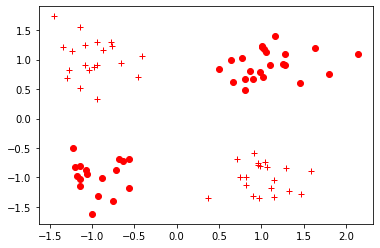

In [ ]:
def vis_data(x, y = None, c = 'r'):

  if y is None: y = [None] * len(x)
  for x_, y_ in zip(x, y):
    if y_ is None: plt.plot(x_[0], x_[1], '*', markerfacecolor = 'none', markeredgecolor = c)
    else: plt.plot(x_[0], x_[1], c+'o' if y_ == 0 else c+'+')

plt.figure()
vis_data(train_x, train_y, c='r')
plt.show()

In [ ]:
## numpy 형태의 데이터를 텐서로 변환
train_x = torch.FloatTensor(train_x)
train_y = torch.FloatTensor(train_y)

test_x = torch.FloatTensor(test_x)
test_y = torch.FloatTensor(test_y)

### **(c) 신경망 구성하는 코드**

In [ ]:
class NN(torch.nn.Module):
  def __init__(self, input_size, hidden_size):
    ## NN 클래스는 파이토치의 nn.Module 클래스의 속성들을 가지고 초기화
    super(NN, self).__init__()
    self.input_size  = input_size
    self.hidden_size = hidden_size

    ## torch.nn.Linear()는 행렬곱과 편향을 포함하는 연산을 지원하는 객체를 반환
    self.linear1 = torch.nn.Linear(self.input_size, self.hidden_size)
    self.relu    = torch.nn.ReLU()
    self.linear2 = torch.nn.Linear(self.hidden_size, 1)
    self.sigmoid = torch.nn.Sigmoid()

  ## init() 함수에서 정의한 동작들을 차례대로 실행하는 함수 
  def forward(self, input_tensor):
    linear1 = self.linear1(input_tensor)
    relu    = self.relu(linear1)
    linear2 = self.linear2(relu)
    output  = self.sigmoid(linear2)

    return output



- 모델 학습 적용하는 부분

In [ ]:
## 클래스를 호출할 때 torch.nn.Module에서 forward함수를 
## 호출하므로, 따로 forward 함수를 호출할 필요는 없음.
model     = NN(2, 3)
lr        = 3*1e-2
epochs    = 20000

## 로스 함수로는 Binary Cross Entropy 함수 사용
criterion = torch.nn.BCELoss()

## 최적화 함수로는 SGD(Stochastic Gradient Descent)사용.
## 최적화 함수는 step() 함수가 호출될 때마다 가중치를 학습률만큼 갱신
optimizer = torch.optim.SGD(model.parameters(), lr = lr)

In [ ]:
## 학습시키기 전 모델 성능평가
model.eval()
before_test_loss = criterion(model(test_x).squeeze(), test_y)
print(f'Before training test Loss :{before_test_loss.item()}')

Before training test Loss :0.7008140087127686


### **(d) 모델 학습하는 코드**

In [ ]:
for epoch in range(epochs): 
  ## 모델을 학습 모드로 변경해줌
  ## 에폭마다 새로운 경사값을 계산하므로 zero_grad() 함수를 호출,
  ## 경사값을 0으로 설정
  model.train()
  optimizer.zero_grad()

  train_output = model(train_x)
  train_loss   = criterion(train_output.squeeze(), train_y)

  if epoch % 500 == 0:
    print(f'[{epoch} / {epochs}] train loss : {train_loss:.2f}')

  ## 역전파 계산해주는 부분
  train_loss.backward()
  optimizer.step()

[0 / 20000] train loss : 0.72
[500 / 20000] train loss : 0.33
[1000 / 20000] train loss : 0.15
[1500 / 20000] train loss : 0.10
[2000 / 20000] train loss : 0.07
[2500 / 20000] train loss : 0.06
[3000 / 20000] train loss : 0.05
[3500 / 20000] train loss : 0.04
[4000 / 20000] train loss : 0.03
[4500 / 20000] train loss : 0.03
[5000 / 20000] train loss : 0.03
[5500 / 20000] train loss : 0.02
[6000 / 20000] train loss : 0.02
[6500 / 20000] train loss : 0.02
[7000 / 20000] train loss : 0.02
[7500 / 20000] train loss : 0.02
[8000 / 20000] train loss : 0.02
[8500 / 20000] train loss : 0.02
[9000 / 20000] train loss : 0.01
[9500 / 20000] train loss : 0.01
[10000 / 20000] train loss : 0.01
[10500 / 20000] train loss : 0.01
[11000 / 20000] train loss : 0.01
[11500 / 20000] train loss : 0.01
[12000 / 20000] train loss : 0.01
[12500 / 20000] train loss : 0.01
[13000 / 20000] train loss : 0.01
[13500 / 20000] train loss : 0.01
[14000 / 20000] train loss : 0.01
[14500 / 20000] train loss : 0.01
[150

In [ ]:
## 학습 후 모델 성능 평가
model.eval()
after_test_loss = criterion(torch.squeeze(model(test_x)), test_y)
print(f'after training test Loss : {after_test_loss}')

after training test Loss : 0.0031160390935838223


### **(e) 학습시킨 모델 저장하는 부분**
- 학습된 모델을 state_dict() 함수 형태로 변셩하여 pt파일로 저장  
(!) state_dict() 함수는 모델 내 가중치들이 딕셔너리 형태로 표현된 데이터

In [ ]:
torch.save(model.state_dict(), './model.pt')
print(f'state dict format of the model : \n{model.state_dict()}')

state dict format of the model : 
OrderedDict([('linear1.weight', tensor([[ 2.8389,  2.9249],
        [-3.1837, -2.7102],
        [ 0.4108,  0.1128]])), ('linear1.bias', tensor([-1.4428, -1.8443, -0.8169])), ('linear2.weight', tensor([[-4.2566, -4.5343,  0.4090]])), ('linear2.bias', tensor([5.6307]))])


### **(f) 저장된 모델 불러와서 사용하기**
- 새로운 모델 객체 new_model을 생성하여 앞서 학습시킨 모델을 불러옴.


In [ ]:
new_model = NN(2, 3)
new_model.load_state_dict(torch.load('./model.pt'))

new_model.eval()
score = new_model(torch.FloatTensor([-1, 1])).item()
print(f'벡터 [-1, 1]이 레이블 1을 가질 확률은 {score}')

벡터 [-1, 1]이 레이블 1을 가질 확률은 0.9964268803596497
